<a href="https://colab.research.google.com/github/dowrave/RoadToImageSeg_GAN/blob/main/220511_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[텐서플로우 튜토리얼](https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko)

### AutoEncoder
- 입력을 출력에 복사하도록 훈련된 특수한 유형의 신경망
- 이미지 -> 낮은 차원의 잠재 표현 (인코딩) -> 이미지 (디코딩)
  - 재구성 오류를 최소화하면서 데이터 압축 방법을 학습함

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [4]:
# 2개의 Dense Layer로 AutoEncoder 정의하기
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    # encoder : input 이미지 -> Flatten -> latent_dim 개로 축소
    self.encoder = tf.keras.Sequential([
                                        layers.Flatten(),
                                        layers.Dense(latent_dim, activation = 'relu') # relu를 쓰네~
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(784, activation = 'sigmoid'), # sigmoid를 쓰네~
                                        layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [5]:
autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError())

In [6]:
# 기본 : Model을 상속받았으니 fit도 가능하겠죠?
autoencoder.fit(x_train, x_train, # Target이 x_train인 것에 유의!
                epochs = 10,
                shuffle = True,
                validation_data = (x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 0.0237 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

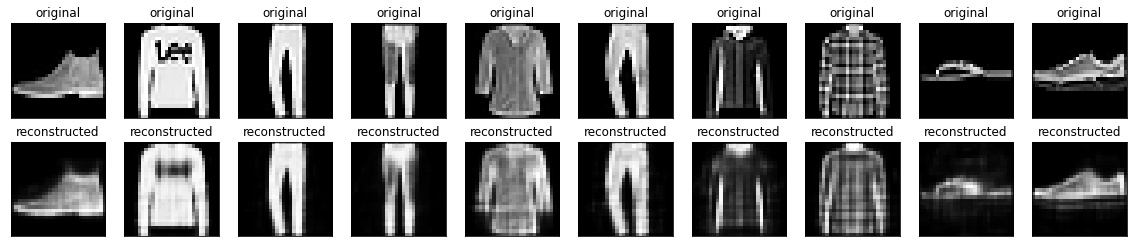

In [8]:
n = 10
plt.figure(figsize = (20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 예제 2. 이미지 노이즈 제거

In [34]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [35]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [36]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape = x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape = x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min = 0., clip_value_max = 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min = 0., clip_value_max = 1.)

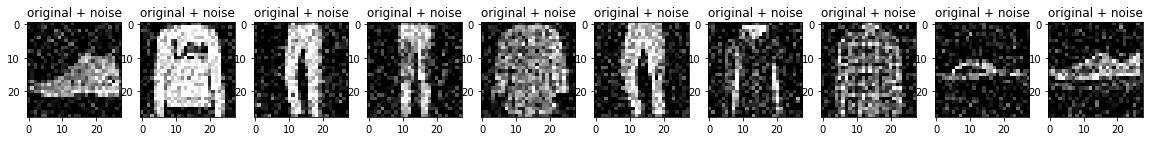

In [37]:
# 노이즈 이미지 플롯하기
n = 10
plt.figure(figsize = (20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
plt.show()

# Convolutional Autoencoder 정의하기

In [47]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = Denoise()

In [48]:
autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError())

# 노이즈 데이터와 원본 데이터를 같이 넣음 -> 노이즈를 제거하도록 학습
autoencoder.fit(x_train_noisy, x_train, epochs = 10, shuffle  = True, validation_data = (x_test_noisy, x_test)) 

Epoch 1/10
1875/1875 [==============================] - 22s 7ms/step - loss: 0.0162 - val_loss: 0.0097
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/10
1875/1875 [==============================] - 14s 8ms/step - l

In [49]:
print(autoencoder.encoder.summary())
print(autoencoder.decoder.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)               

In [52]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

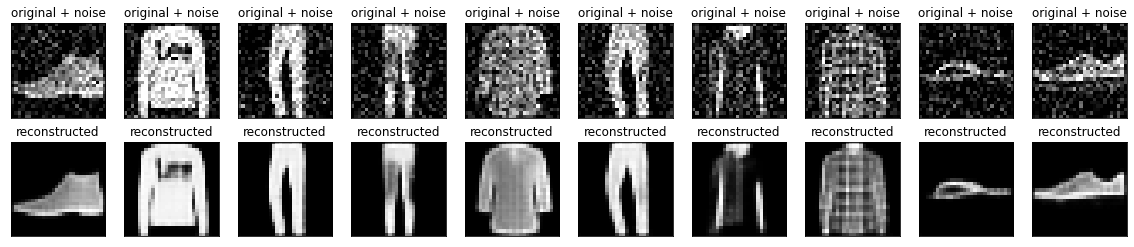

In [56]:
n = 10
plt.figure(figsize = (20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 3. 이상 감지
- ECG5000 (심전도) 데이터세트에서 이상 감지하는 훈련
- 140개의 포인트, 5000개의 샘플
- 각 예제는 0(비정상), 1(정상) 으로 레이블이 지정되어 있음


In [59]:
# 데이터셋
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header = None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [63]:
# 가장 마지막 element는 label
labels = raw_data[:, -1]

# 그 앞의 element들은 심전도 데이터
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size = 0.2, random_state = 21
)

In [64]:
# 정규화
min_val = tf.reduce_min(train_data) # 텐서 차원의 요소 중 최솟값 구하기
max_val = tf.reduce_max(train_data)

# minmax Normalization
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [65]:
# 정상 리듬(label = 1)만 사용하여 autoencoder 훈련
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

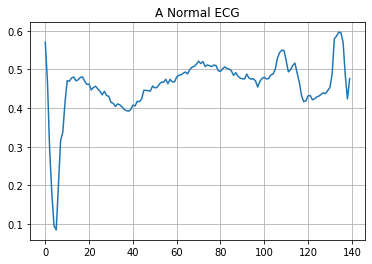

In [67]:
# 정상 ECG 플롯
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

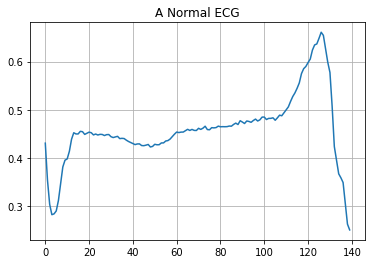

In [68]:
# 비정상 ECG 플롯
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('A Normal ECG')
plt.show()

In [71]:
# 모델 빌드
class Anomalydetector(Model):
  def __init__(self):
    super(Anomalydetector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.Dense(32, activation = 'relu'),
                                        layers.Dense(16, activation = 'relu'),
                                        layers.Dense(8, activation = 'relu')
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(16, activation = 'relu'),
                                        layers.Dense(32, activation = 'relu'),
                                        layers.Dense(140, activation = 'sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Anomalydetector()

In [72]:
autoencoder.compile(optimizer = 'adam', loss = 'mae')

In [73]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs = 20,
                          batch_size = 512,
                          validation_data = (test_data, test_data),
                          shuffle = True)

Epoch 1/20
5/5 [==============================] - 2s 88ms/step - loss: 0.0589 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0566 - val_loss: 0.0523
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0548 - val_loss: 0.0508
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0527 - val_loss: 0.0491
Epoch 5/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0501 - val_loss: 0.0475
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0470 - val_loss: 0.0461
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0437 - val_loss: 0.0450
Epoch 8/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0405 - val_loss: 0.0436
Epoch 9/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0374 - val_loss: 0.0422
Epoch 10/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0347 - val_loss: 0.0411
Epoch 11/20
5/5 [============

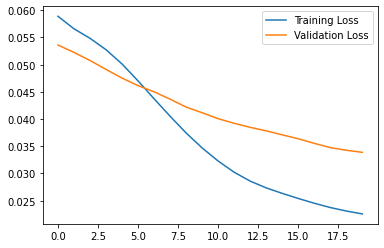

In [74]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()

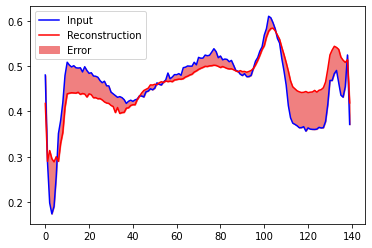

In [75]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b') # 파란선 : 정상 데이터(원본)
plt.plot(decoded_imgs[0], 'r') # 붉은선 : Autoencoder의 결과(만들어진 것)
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color = 'lightcoral') # 둘의 차이 = 붉은 영역(Error)
plt.legend(labels = ['Input', 'Reconstruction', 'Error'])
plt.show()

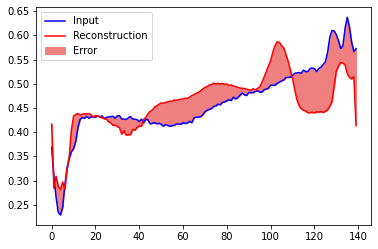

In [76]:
# 테스트 데이터에 대해
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b') # 파란선 : 정상 데이터(원본)
plt.plot(decoded_imgs[0], 'r') # 붉은선 : Autoencoder의 결과(만들어진 것)
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color = 'lightcoral') # 둘의 차이 = 붉은 영역(Error)
plt.legend(labels = ['Input', 'Reconstruction', 'Error'])
plt.show()

### 이상 감지 : 임계값을 설정, 이보다 크면 이상이라고 한다
- 임계값 설정 : 정상 예제에 대한 평균 오차 계산 -> 재구성 오류가 훈련 세트의 표준편차보다 크다면 예제는 비정상으로 간주

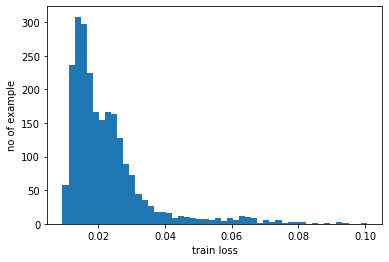

In [78]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data) 

plt.hist(train_loss, bins = 50)
plt.xlabel("train loss")
plt.ylabel("no of example")
plt.show()

In [79]:
threshold = np.mean(train_loss) + np.std(train_loss)
print(threshold)

0.034131475


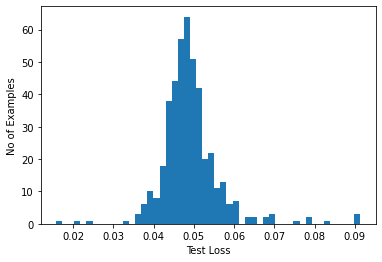

In [83]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins = 50)
plt.xlabel("Test Loss")
plt.ylabel("No of Examples")
plt.show()

In [85]:
def predict(model, data, thresohld):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold) # less(x,y) : x < y일 때 True 반환

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [86]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429
